# Notebook for Training a Tabular Neural Net

In [1]:
import pandas as pd
import numpy as np
from fastai.tabular import *

In [2]:
import fastai; fastai.__version__

'1.0.51.dev0'

#### Read in data, drop any superfluous variables

In [3]:
df = pd.read_csv('data/data_clean.csv',low_memory=False,index_col=0)

In [4]:
drop_cols = ['l_name','l_name_romaji','rownullsums','blooming_date','day']

In [5]:
df.drop(drop_cols,axis=1,inplace=True);

In [6]:
df.reset_index(drop=True,inplace=True)

#### Declare variable types

In [7]:
df.dtypes[df.dtypes=='object'] # all variables are set appropriately

Series([], dtype: object)

In [21]:
cats = ['l_code','rm']
dep_var = 'days_since_yr_start'

In [24]:
conts = np.setdiff1d(df.columns,cats.copy())

In [27]:
conts = np.setdiff1d(conts,[dep_var])

#### Declare Pre-processors

In [28]:
procs = [FillMissing, Categorify, Normalize]

#### Decide on schema for splitting into train, validation, and test sets

- For validation, let's use the last 7 years  of data minus the last 2 years (so 5 years of data)

- For testing, we'll use the last 2 years.

In [29]:
df.year.max()

2018

In [30]:
test = df.loc[df.year >= 2017]

In [31]:
valid_idx = df.loc[((df.year > 2011) & (df.year < 2017)),:].index.values

#### Prepare data for neural network (create data bunch)

In [32]:
df.shape

(4912, 553)

In [33]:
data = (TabularList.from_df(df, cat_names=cats, cont_names=conts, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test, cat_names=cats, cont_names=conts))
                .databunch())

## Train NN

##### Tweak Y Range

In [35]:
np.max(df['days_since_yr_start'])*1.5

240.0

In [36]:
max_log_y = np.log(np.max(df['days_since_yr_start'])*1.5) 
# this makes since, since we don't expect to see huge deviations from past bloom behavior 
# (i.e. greather than 1.5x the max days from year start
y_range = torch.tensor([0, max_log_y], device=defaults.device)

##### Instantiate Learner

In [40]:
learn = tabular_learner(data, layers=[200,100], ps=[0.001,0.01], emb_drop=0.25, 
                        y_range=y_range, metrics=exp_rmspe)

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


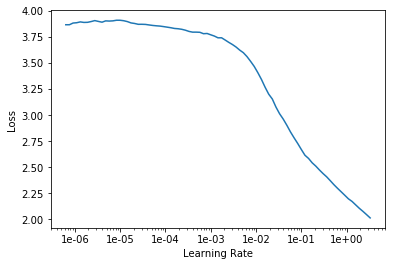

In [42]:
learn.recorder.plot()

In [ ]:
plt.barh(nullcols.index,nullcols.values)
plt.title('Most missing data for weather indicator 11')

In [ ]:
nullcols = df.isnull().sum(axis=0)
nullcols = nullcols[nullcols > 0]

nullcols = nullcols[nullcols > nullcols.quantile(.95)]

In [ ]:
plt.bar(rownulls.value_counts().index,rownulls.value_counts().values)
plt.title('Distribution of missing value counts for rows in 95% quantile')